In [67]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from keras.datasets import cifar10

from sklearn.preprocessing import Normalizer

In [2]:
logging_format = '%(levelname)s -> %(message)s'
logging.basicConfig(format=logging_format, level=logging.INFO)

# The Vanishing/Exploding Gradient Problems

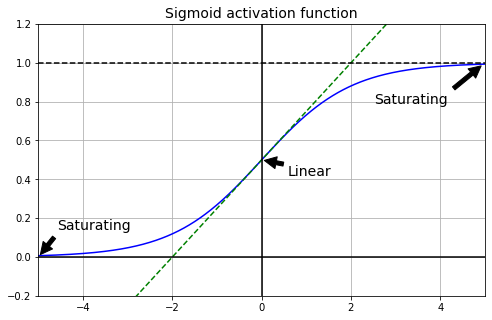

In [3]:
x = np.arange(-5, 5, step=0.01)
sigmoid = 1 / (1 + np.exp(-x))
diagonal = 0.5 + 0.25*x

plt.figure(figsize=(8, 5))

plt.plot(x, sigmoid, 'b-')
plt.plot(x, diagonal, 'g--')
plt.vlines(0, -2, 3, colors='black')
plt.hlines(0, -5, 5, colors='black')
plt.hlines(1, -5, 5, colors='black', linestyles='dashed')

plt.xlim(-5, 5)
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.title('Sigmoid activation function', fontsize=14)

plt.annotate('Saturating',
             xy=[5, 1],
             xytext=(0.65, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.annotate('Saturating',
             xy=[-5, 0],
             xytext=(0.10, 0.25),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.annotate('Linear',
             xy=[0, 0.5],
             xytext=(0.5, 0.40),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.show()

## Glorot and He Initialization

- Glorot initialization (when using logistic activation function)

> Normal distribution with mean $0$ and variance $\sigma^2 = \frac{1}{\text{fan}_{\text{avg}}}$
>
> Or a uniform distribution between $-r$ and $+r$, with $r=\sqrt{\frac{3}{\text{fan}_{\text{avg}}}}$
>
> - Where $\text{fan}_{\text{avg}} = \frac{ \text{fan}_{\text{in}} + \text{fan}_{\text{out}} }{2}$ , and $\text{fan}_{\text{in}}$ is the number of input neurons of the layer, and $\text{fan}_{\text{out}}$ is the number of output neurons of the layer.

In [4]:
# Change the initialization from Glorot to He
layers.Dense(10, activation='relu', kernel_initializer='he_normal') # the kernel can also be 'he_uniform'

# Use the He initiaization based on fan-avg instead of fan-in
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg', distribution='uniform')
layers.Dense(10, activation='relu', kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

The ReLU function suffers from the problem of dying ReLUs, this means that some neurons will output 0. This happens when the sum of all their weights are negative, giving 0 as output.

To avoid this problem is recommended to use variantes of ReLU.

- LeakyReLU
> $\text{LeakyReLU}_{\alpha}(z) = \text{max}(\alpha z, z)$
>
> - Where the hyperparameter $\alpha$ defines how much the function 'leaks'

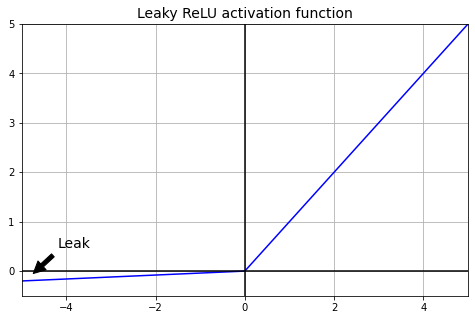

In [5]:
alpha = 0.04
leaky_relu = np.maximum(alpha * x, x)

plt.figure(figsize=(8, 5))

plt.plot(x, leaky_relu, 'b-')
plt.vlines(0, -2, 6, colors='black')
plt.hlines(0, -5, 5, colors='black')

plt.xlim(-5, 5)
plt.ylim(-0.5, 5)
plt.grid(True)
plt.title('Leaky ReLU activation function', fontsize=14)

plt.annotate('Leak',
             xy=[-4.8, -0.1],
             xytext=(0.10, 0.2),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1))

plt.show()

Djork-Arné Clevert et al. proposed a new activation function that outperformed all the ReLU variants in test set and the training time was reduced:

- Exponential Linear Unit (ELU)
> ELU $_\alpha (z) = \begin{cases} \alpha(exp(z) - 1) & \text{if }z<0 \\ z & \text{if }z\ge0\end{cases}$

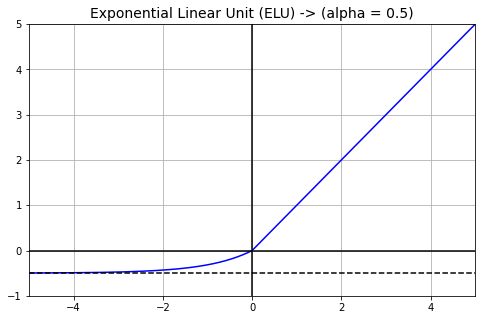

In [6]:
alpha_elu = 0.5
elu = np.where(x < 0, alpha_elu * (np.exp(x) - 1), x)

plt.figure(figsize=(8, 5))

plt.plot(x, elu, 'b-')
plt.vlines(0, -2, 6, colors='black')
plt.hlines(-alpha_elu, -5, 5, colors='black', linestyles='dashed')
plt.hlines(0, -5, 5, colors='black')

plt.xlim(-5, 5)
plt.ylim(-1, 5)
plt.grid(True)
plt.title(f'Exponential Linear Unit (ELU) -> (alpha = {alpha_elu})', fontsize=14)

plt.show()

## Batch Normalization

Batch Normalization (BN) is the technique of adding an operation in the model to zero-center and normalize the input. In order to do it, the algorithm needs to calculate each input's mean and standard deviation. It does it, evaluating the mean and standard deviation of each mini-batch.

The algorithm to zero-center and normalize the inputs is:

- Calculates the vector of input means $\mu_{B}$
> $\mu_{B} = \frac{1}{m_B}\sum\limits_{i=1}^{m_B}{\textbf{x}^{(i)}}$

- Then, calculates the vector of input standard deviations $\sigma_B^2$
> $\sigma_B^2 = \frac{1}{m_B}\sum\limits_{i=1}^{m_B}{(\textbf{x}^{(i)} - \mu_B)^2}$

- Calculates the vector $\hat{x}^{(i)}$ of zero-centered and normaliez inputs for instance $i$
> $\hat{x}^{(i)} = \frac{ \textbf{x}^{(i)} - \mu_B }{ \sqrt{\sigma_B^2 + \varepsilon} }$
> - Where $\varepsilon$ is a tiny number to avoid division by zero.

- Finally, calculates the output of the BN operation, that is a rescaled and shifted version of the inputs
> $Z^{(i)} = \gamma \otimes \hat{x}^{(i)} + \beta$
> - Where $\gamma$ is the output scales parameter vector for the layer, $\otimes$ represents the element-wise multiplication, and $\beta$ is the ouput shift (offset) parameter vector of the layer.

### Implementing Batch Normalization with Keras

In [7]:
# Initialize a model with Batch Normalization after every layer

model = models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.BatchNormalization(),
    layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax'),
])

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2021-12-14 11:20:28.843486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-14 11:20:28.843619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [9]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [10]:
model.layers[1].updates

/var/folders/w1/7wtz55rs63b9743vzqfb8p880000gp/T/ipykernel_38951/3873162892.py:1: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  model.layers[1].updates


[]

The previous implementation adds the BN layer after the activation function, however the authors of the paper argued in favor of adding the BN layer before the activation function. To do so, it is necessary to remove the activation function of the layer, and then add the activation function after the BN layer.

In [11]:
model = models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.BatchNormalization(),
    layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('elu'),
    layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('elu'),
    layers.Dense(10, activation='softmax')
])

## Gradient Clipping

In [12]:
# Implement Gradient Clipping using Keras

optimizer = keras.optimizers.SGD(clipvalue=1)
model.compile(loss='mse', optimizer=optimizer)

## Reusing Pretrained Layers

## Transfer Learning with Keras

Let's first train a model for classification for the fashion MNIST dataset.

In [13]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

x_valid, x_train = x_train_full[:5000] / 255, x_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [14]:
def evaluate_model(activation='relu', kernel_initializer='he_normal', n_neurons=300, batch_size=32):
    
    model_fashion = models.Sequential([
        layers.Flatten(input_shape=[28, 28]),
        layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer),
        layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer),
        layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer),
        layers.Dense(10, activation='softmax')
    ])

    early_stopping_cb = callbacks.EarlyStopping(patience=10, 
                                                restore_best_weights=True)

    model_fashion.compile(loss='sparse_categorical_crossentropy',
                        optimizer='sgd',
                        metrics=['accuracy'])

    history = model_fashion.fit(x_train, y_train, 
                    epochs=150, 
                    validation_data=(x_valid, y_valid), 
                    verbose=0, 
                    callbacks=[early_stopping_cb], 
                    use_multiprocessing=True,
                    batch_size=batch_size)
    
    model_fashion.save('models/model_fashion.h5')
    
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.title(f'Training the model using {activation} with {kernel_initializer} and batch of {batch_size}')
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.show()

2021-12-14 11:20:29.606732: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-14 11:20:29.730333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 11:20:31.964358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


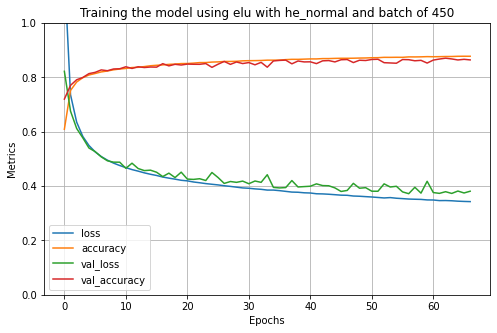

In [15]:
n_neurons = 100
batch_size = 450

evaluate_model(activation='elu', n_neurons=n_neurons, batch_size=batch_size)

Then, lets create the dataset with 300 instances having only bags and dresses. The classes are:

|Label|Description|
|:----:|:-----:|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle Boot|

In this case, we need to select only the data with classes 3 and 8. Let's First create the new training set and then the test set:

In [16]:
# Get the new training set for the binary classification

y_train_filter = []

for y in y_train_full:
    
    if y == 3 or y == 8:
        y_train_filter.append(True)
    else:
        y_train_filter.append(False)

x_train_binary = x_train_full[y_train_filter][:400]
y_train_binary = y_train_full[y_train_filter][:400]
y_train_binary = np.where(y_train_binary == 3, 1, 0)

x_train_binary, x_valid_binary = x_train_binary[:300] / 255, x_train_binary[300:] / 255
y_train_binary, y_valid_binary = y_train_binary[:300], y_train_binary[300:]

# Get the new test set

y_test_filter = []

for y in y_test:
    if y == 3 or y == 8:
        y_test_filter.append(True)
    else:
        y_test_filter.append(False)

x_test_binary = x_test[y_test_filter][:100]
y_test_binary = y_test[y_test_filter][:100]
y_test_binary = np.where(y_test_binary == 3, 1, 0)


In [17]:
x_test_binary.shape

(100, 28, 28)

Now, let's call the previously saved model and reuse the hidden layers:

In [18]:
model_fashion = models.load_model('models/model_fashion.h5')

# Clone the pretrained model

model_fashion_clone = models.clone_model(model_fashion)
model_fashion_clone.set_weights(model_fashion.get_weights())

In [19]:
model_fashion_binary = models.Sequential(model_fashion_clone.layers[:-1])
model_fashion_binary.add(layers.Dense(1, activation='sigmoid'))

# Freeze the hidden layers of the pretrained model
for layer in model_fashion_binary.layers[:-1]:
    layer.trainable = False

model_fashion_binary.compile(loss='binary_crossentropy', 
                             optimizer='sgd', 
                             metrics=['accuracy'])

history = model_fashion_binary.fit(x_train_binary, y_train_binary,
                                   epochs=10,
                                   batch_size=100,
                                   validation_data=(x_valid_binary, y_valid_binary),
                                   verbose=0)

# Unfreeze the hidden layers of the pretrained model
for layer in model_fashion_binary.layers[:-1]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=1e-4)
model_fashion_binary.compile(loss='binary_crossentropy',
                             optimizer=optimizer,
                             metrics=['accuracy'])

history = model_fashion_binary.fit(x_train_binary, y_train_binary,
                                   epochs=25,
                                   validation_data=(x_valid_binary, y_valid_binary),
                                   verbose=0)

logging.info(f'The Accuracy of the model that reused the pretrained layers is {model_fashion_binary.evaluate(x_test_binary, y_test_binary)}')

2021-12-14 11:21:57.667137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 11:21:57.945698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/mmenendezg/.local/share/virtualenvs/Books-uCdQc7s-/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2021-12-14 11:21:58.425260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 11:21:58.845478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 11ms/step - loss: 7.6986 - accuracy: 0.9300


2021-12-14 11:22:01.914786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
INFO -> The Accuracy of the model that reused the pretrained layers is [7.698592185974121, 0.9300000071525574]


# Faster Optimizers

## Momentum Optimization

The regular Gradient Descent updates the weights $\theta$ by substracting the gradient of the function $J(\theta)$ with regards to the weights $(\nabla J(\theta))$ multiplied by the learning rate $\eta$.

- Gradient Descent 
> $\theta \gets \theta - \eta \nabla_\theta J(\theta)$

However, the momentum optimization takes into consideration the previous gradients. To update the weights, it substract the local gradient from the momentum vector $m$. It also adds the the hyperparameter $\beta$, called the momentum, that acts like friction. This hyperparameter $\beta$ avoids the momentum vector $m$ from growing too large.

- Momentum algorithm
> $1. \quad m \gets \beta m - \eta \nabla_\theta J(\theta)$
>
> $2. \quad \theta \gets \theta + m$

Let's implement *Momentum Optimization* in Keras:

In [20]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

The *Nesterov Accelerated Gradient* (NAG) is a variant of the *Momentum Optimization* algorithm. Instead of measuring the gradient of the cost function in the local position, measures the gradient slightly ahead in the direction of the momentum at $\theta + \beta m$.

- Nesterov Accelerated Gradient algorithm
> $1. \quad m \gets \beta m - \eta \nabla_\theta J(\theta + \beta m)$
> 
> $2. \quad \theta \gets \theta + m$

Let's implement NAG using Keras:

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

- AdaGrad algorithm
> $1. \quad s \gets s + \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta) \quad \Leftarrow \quad$ Here the operator $\otimes$ is element-wise multiplication, this vectorized form is equivalent to $s_i \gets s_i + (\frac{ \partial J(\theta) }{ \partial \theta_i })^2$
>
> $2. \quad \theta \gets \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\varepsilon} \quad \Leftarrow \quad$ Here the operator $\oslash$ is element-wise division, and $\varepsilon$ is a smoothing term to avoid division by zero.

This algorithm works great for quadratic problems, but when training neural networks it stops early. This should not be used to train DNN.

## RMSProp

The *RMSProp* algorithm solves the inconvenience of the *AdaGrad* algorithm by saving only the gradients of the recent iterations.

- RMSProp algorithm
> $1. \quad s \gets \beta s + (1 - \beta)\nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta) \quad \Leftarrow \quad$ The hyperparameter $\beta$ controls the decay rate
>
> $2. \quad \theta \gets \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\varepsilon}$

Let's implement it in Keras:

In [22]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam and Nadam Optimization

*Adam* (Adaptive moment estimation) combines the ideas of *momentum optimization* and *RMSProp*.

- Adam Algorithm
> $1. \quad m \gets \beta_1m - (1-\beta_1) \nabla_\theta J(\theta) \quad \Leftarrow \quad $ This is the momentum part of the algorithm
>
> $2. \quad s \gets \beta_2s - (1-\beta_2) \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta) \quad \Leftarrow \quad $ This is the RMSProp alike part of the algorithm
>
> $3. \quad \hat{m} \gets \frac{ m }{ 1 - \beta_1^t } \quad \Leftarrow \quad $ Here $t$ represents the iteration number
>
> $4. \quad \hat{s} \gets \frac{ s }{ 1 - \beta_2^t }$
>
> $5. \quad \theta \gets \theta + \eta \hat{m} \oslash \sqrt{ \hat{s} + \varepsilon }$

Let's implement the *Adam* optimization with Keras:

In [23]:
adam_optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

Finding a good *learning rate* is important for the training of a DNN: too high and training may diverge, too low and it may converge but it will take ages. 

Instead of using a static learning rate, we can use learning schedules: reduce the learning rate with the iterations.

Some of the most common *learning schedules*:

- **Power Scheduling**: This reduces the learning rate $\eta$ quick first, and then slower and slower. Here, $\eta$ is set to a function of the iterations $t$: $\eta (t) = \eta_0 (1+\frac{t}{s})^c$

In [24]:
# Implement the power scheduling

optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)


- **Exponential Scheduling**: This scheduling reduces the *learning rate* by a factor of 10 every $s$ steps. Set the learning rate to $\eta(t)=\eta_0 0.1^{\frac{t}{s}}$

To implement *exponential scheduling* and *piecewise scheduling* it is first required to have a function that takes the current epoch and returns the learning rate:

In [25]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

# It is possible to return a function that is configured with eta and s

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

# Then we create call the function and pass it to the callback LearningRateScheduler

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = callbacks.LearningRateScheduler(exponential_decay_fn)

# Here lr_scheduler can be given to the model as a callback when calling the fit() method


- **Piecewise constant scheduling**: Use a constant learning by $s$ steps, then changes to a smaller learning rate by other $s$ steps, and so on.

In order to implement the *piecewise constant scheduling*, we can use the following function:

In [26]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
    
# Then we create call the function and pass it to the callback LearningRateScheduler

lr_scheduler = callbacks.LearningRateScheduler(piecewise_constant_fn)

- **Performance scheduling**: Measures the validation error every $N$ steps and reduces the learning rate by $\lambda$ when the error stop dropping.

For the *performance scheduling* use the ```ReduceLROnPlateau``` callback:

In [27]:
lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

Alternatively, ```tf.keras``` offer the option to use the schedules available in ```tf.keras.optimizers.schedules```. This updates the *learning rate* at each step instead of each epoch.

In [28]:
s = 20 * len(x_train) // 32 # number of steps in 20 epochs (batche_size=32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

# Avoid Overfitting Through Regularization

## $l_1$ and $l_2$ Regularization

In [29]:
layer = layers.Dense(100, activation='elu',
                     kernel_initializer='he_normal',
                     kernel_regularizer=keras.regularizers.l2(0.01))

The previous code uses the $l2$ regularization for the layer. It is possible to use instead ```keras.regularizers.l1()``` for $l1$, or using ```keras.regularizers.l1_l2()``` for a combination of both.

In [30]:
from functools import partial

RegularizedDense = partial(layers.Dense,
                           activation='elu',
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax', kernel_initializer='glorot_uniform')
])

## Dropout

The idea behind this is that at every step the neurons have a probability of being temporarily dropped, and then being reactivated at the following step.

In [31]:
RegularizedDense = partial(layers.Dense,
                           activation='elu',
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = models.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dropout(rate=0.2),
    RegularizedDense(300),
    layers.Dropout(rate=0.2),
    RegularizedDense(100),
    layers.Dropout(rate=0.2),
    RegularizedDense(10, activation='softmax', kernel_initializer='glorot_uniform')
])

## Monte Carlo (MC) Dropout

The idea behind Monte Carlo Dropout is making several predictions with the dropouts layers active and then averaging the results. This makes a more reliable result than one single prediction with the dropout layers off. To activate the dropout in the predictions we can use ```model(x_test, training=True)``` when calling the model.

In [32]:
y_probas = np.stack([model(x_test, training=True) for sample in range(100)])

y_proba = y_probas.mean(axis=0)

In [33]:
np.round(model.predict(x_test[:1], 2))

2021-12-14 11:22:04.781391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [34]:
np.round(y_proba[:1], 2)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [35]:
y_std = y_probas.std(axis=0)

logging.info(f'The standard deviation of the predictions is {np.round(y_std[:1], 5)}')

INFO -> The standard deviation of the predictions is [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Another way of implementing the MC Dropout to avoid activating other layers that behave different in training is this one:

In [36]:
class MCDropout(layers.Dropout):
    def call(self,  inputs):
        return super().call(inputs, training=True)

## Max-Norm Regularization

The *Max-Norm Regularization* constrains the weight of the input connection of the layer, applying the $l_2$ norm, computing $||w||_2$, and limiting the weight to $||w||_2 \le r$. Here, $r$ is a hyperparameter to tweak.

To apply it, we can use the ```keras.contraints.max_norm()``` method as below:

In [37]:
layers.Dense(100, activation='relu',
             kernel_initializer='he_normal',
             kernel_constraint=keras.constraints.max_norm(1))

# Exercises

## Questions 1-7

1. Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?

> No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It’s like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.

2. Is it OK to initialize the bias terms to 0?

> Initializing the bias terms to zero should not cause any inconvenience, since these will be updated in the training through backpropagation.

3. Name three advantages of the SELU activation function over ReLU.

> - The SELU activation may self-normalize the outputs of the layer, solving the vanishing/exploding gradient problem
>
> - It can take on negative values, so the average output of the neurons in any given layer is typically closer to zero than when using the ReLU activation function (which never outputs negative values). This helps alleviate the vanishing gradients problem.
>
> - It always has a nonzero derivative, which avoids the dying units issue that can affect ReLU units.

4. In which cases would you want to use each of the following activation functions: SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?

> - The SELU activation is a great option when the net structure allows to be self-normalized: Sequential structure of the network, the input features standardized, LeCunn normal initialization as ```kernel_initializer``` and all the layers are Dense.
> - leaky ReLU and its variants are a great option when the network does not allow self-normalization, and low latency is not quite important in our model.
> - ReLU is a great option if low latency is important in the model.
> - tanh if the output expected varies from -1 and 1.
> - logistics is the activation for binary classification
> - Softmax is the activation function to use when we have a multioutput model.

5. What may happen if you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer?

> - If you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller momentum value.

6. Name three ways you can produce a sparse model.

> It is possible to produce a sparse model by applying regularization with $l_1$. Another way of obtaining a sparse model is using the TensorFlow Model Optimization Toolkit. 

7. Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What about MC Dropout?

> Dropout only slows down the training, but not in the inference since the layers are not active during inference. On the other side, the MC Dropout slows down both training due to the fact that uses regular Dropout, and inference since it has to make $n$ predictions (this is a hyperparameter to tune), and the averages the inferences to have a more reliable prediction.

# Question 8

- See the file **ex_11.ipynb**